In [0]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn.init import kaiming_normal_

In [4]:
torch.cuda.get_device_name()

'Tesla K80'

In [81]:
transform_compose = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_data = datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform_compose)
validation_data = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform_compose)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw





Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [7]:
train_data, type(train_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                ToTensor()
            ), torchvision.datasets.mnist.MNIST)

In [0]:
train_loader = DataLoader(dataset = train_data, batch_size = 1000, shuffle = True)
validation_loader = DataLoader(dataset = validation_data, batch_size = 1000, shuffle = False)

In [0]:
class CNN(nn.Module):
    def __init__(self, out_1 = 16, out_2 = 32):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = out_1, kernel_size = 5)
        # self.drop2d1 = nn.Dropout2d(p = 0.35, inplace = True)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.batch_norm1 = nn.BatchNorm2d(out_1, momentum = 0.5)

        self.conv2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5)
        # self.drop2d2 = nn.Dropout2d(p = 0.35, inplace = True)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_2, momentum = 0.5)
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(10368, 200)
        self.drop1 = nn.Dropout(p = 0.35, inplace = True)
        self.linear2 = nn.Linear(200, 100)
        self.drop2 = nn.Dropout(p = 0.35, inplace = True)
        self.linear_output = nn.Linear(100, 10)

        kaiming_normal_(self.conv1.weight, nonlinearity = 'relu')
        kaiming_normal_(self.conv2.weight, nonlinearity = 'relu')
        kaiming_normal_(self.linear1.weight, nonlinearity = 'relu')
        kaiming_normal_(self.linear2.weight, nonlinearity = 'relu')
        kaiming_normal_(self.linear_output.weight, nonlinearity = 'relu')

    def forward(self, x):
        x = self.conv1(x)
        # x = self.drop2d1(x)
        x = self.maxpool1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        # x = self.drop2d1(x)
        x = self.maxpool2(x)
        x = self.batch_norm2(x)
        x = torch.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.drop2(x)
        x = self.linear_output(x)
        return x

In [0]:
model = CNN()

In [0]:
def train_model(model, criterion, optimizer, train_loader, validation_loader, epochs = 25):
    training_loss = []
    validation_accuracy = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model.forward(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())
        correct = 0
        for x, y in validation_loader:
            model.eval()
            z = model(x)
            _, y_hat = torch.max(z, 1)
            correct += (y_hat == y).sum().item()
        accuracy = 100 * (correct / len(validation_data))
        validation_accuracy.append(accuracy)
        print('epoch: ', epoch, ' validation accuracy: ', validation_accuracy[epoch])
    return training_loss, validation_accuracy

In [0]:
learning_rate = 0.01
cnn_params = model.parameters()
optimizer = torch.optim.Adam(cnn_params, lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [83]:
training_loss, validation_accuracy = train_model(model, criterion, optimizer, train_loader, validation_loader)

epoch:  0 , validation accuracy:  75.76
epoch:  1 , validation accuracy:  81.75
epoch:  2 , validation accuracy:  84.96000000000001
epoch:  3 , validation accuracy:  85.50999999999999
epoch:  4 , validation accuracy:  86.56
epoch:  5 , validation accuracy:  87.55
epoch:  6 , validation accuracy:  87.64999999999999
epoch:  7 , validation accuracy:  87.15
epoch:  8 , validation accuracy:  87.18
epoch:  9 , validation accuracy:  88.23
epoch:  10 , validation accuracy:  88.58
epoch:  11 , validation accuracy:  88.78
epoch:  12 , validation accuracy:  89.07000000000001
epoch:  13 , validation accuracy:  88.13
epoch:  14 , validation accuracy:  88.78
epoch:  15 , validation accuracy:  89.25
epoch:  16 , validation accuracy:  89.16
epoch:  17 , validation accuracy:  88.03999999999999
epoch:  18 , validation accuracy:  88.8
epoch:  19 , validation accuracy:  89.08
epoch:  20 , validation accuracy:  87.71
epoch:  21 , validation accuracy:  89.16
epoch:  22 , validation accuracy:  88.83
epoch:  

In [0]:
import matplotlib.pyplot as plt

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap = 'gray')
    plt.title('y = ' + str(data_sample[1]))

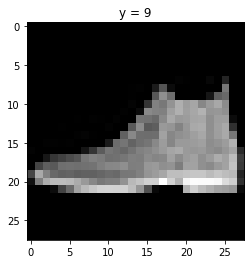

In [89]:
show_data(validation_data[0])

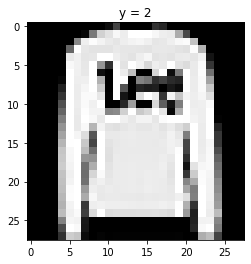

In [90]:
show_data(validation_data[1])

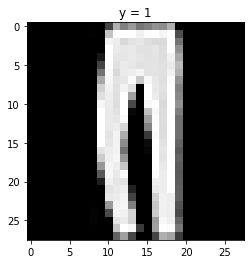

In [91]:
show_data(validation_data[2])

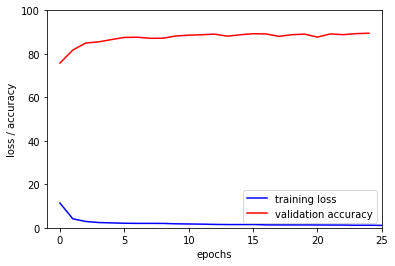

In [96]:
plt.plot(training_loss, label = 'training loss', color = 'blue')
plt.plot(validation_accuracy, label = 'validation accuracy', color = 'red')
plt.ylabel('loss / accuracy')
plt.xlabel('epochs')
plt.ylim(bottom = 0, top = 100)
plt.xlim(left = -1, right = 25)
plt.legend()
plt.show()

In [93]:
print('validation accuracy last epoch: ', validation_accuracy[-1])

validation accuracy last epoch:  89.5
